# Python Learning

Using the Boost.Python library, I compiled my tic-tac-toe `Board` class as a library accessable to python 3.7. 

### To Do:
- Added winner variable to TicTacToe class because it's messy to have to keep calling whoWon()
- Develop DeepQAgent class


In [1]:
import sys
sys.path.append("../lib")

import numpy as np
import tensorflow as tf
import Board

from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class TicTacToe():
    def __init__(self, player1, player2, p1_symbol=1, p2_symbol=-1, p1_exporation=0.8, p2_exporation=0.8):  
        # define two players
        self.p1_symbol = p1_symbol
        self.p1_type = player1
        self.p1_exporation = p1_exporation
        self.p1_name = self.p1_type + str(self.p1_symbol)
        player1 = globals()[self.p1_type]
        self.player1 = player1(symbol=self.p1_symbol, name=self.p1_name, exploration=self.p1_exporation)
        
        self.p2_symbol = p2_symbol
        self.p2_type = player2
        self.p2_exporation = p2_exporation
        self.p2_name = self.p2_type + str(self.p2_symbol)
        player2 = globals()[self.p2_type]
        self.player2 = player2(symbol=self.p2_symbol, name=self.p2_name, exploration=self.p2_exporation)
        
        self.turnPlayer = self.player1
                
        # turn couter
        self.moveCounter = 1
        
        # initialize c++ game
        self.game = Board.Board(int(self.p1_symbol), int(self.p2_symbol))
        
    def reinit(self):
        self.moveCounter = 1
        self.turnPlayer = self.player1
        self.game = Board.Board(int(self.p1_symbol), int(self.p2_symbol))

    def printMoveMap(self):
        print("----------------")
        print("|  0 |  1 |  2 |")
        print("----------------")
        print("|  3 |  4 |  5 |")
        print("----------------")
        print("|  6 |  7 |  8 |")
        print("----------------")
        
    def printGame(self):
        gameBoard = self.game.getBoard()
        print(gameBoard)     
        
    def play_pvp(self):
        self.printMoveMap()
        
        while not self.game.isBoardFull() and self.game.whoWon() == 0:
            print("Turn: ", self.moveCounter, "Player: ", self.game.getTurnPlayer())
            self.printGame()
            
            move = self.turnPlayer.getMove(self.game)
            if self.game.addMove(move):
                # successfully added move, so change turn player
                if self.moveCounter % 2 == 1:
                    self.turnPlayer = self.player2
                else:
                    self.turnPlayer = self.player1
                    
                self.moveCounter += 1
        
        if self.game.whoWon() != 0:
            if self.player1.symbol == self.game.whoWon():
                print("Player", self.player1.name, "(", self.game.whoWon(), ")", "Won!")
            else:
                print("Player", self.player2.name, "(", self.game.whoWon(), ")", "Won!")
        elif self.game.isBoardFull():
            print("Stalemate...")
        else:
            print("Crazy Error: Uncaught stopping condition!")
        
        print("Final Board:")
        self.printGame()
        
    def train(self, ngames, epochs=10, plot=False, plotEveryn=1000, plotSave=False, plotSaveName='train-%d.png'):
        # flush out results (recording and useage)
        results = {'whoWon': np.zeros((ngames)), 'boardFull': np.zeros((ngames))}

        for game in tqdm(range(ngames)):
            while not self.game.isBoardFull() and self.game.whoWon() == 0:
                move = self.turnPlayer.getMove_train(self.game, epochs)
                if self.game.addMove(move):
                    if self.moveCounter % 2 == 1:
                        self.turnPlayer = self.player2
                    else:
                        self.turnPlayer = self.player1

                    self.moveCounter += 1
            
            results['whoWon'][game] = self.game.whoWon()
            results['boardFull'][game] = self.game.isBoardFull()
            self.reinit()
            
            if plot and (game+1)%plotEveryn is 0:
                fig = self.plotRes(results, ngames, ngames//plotEveryn)
                if plotSave:
                    fig.savefig(plotSaveName%game)
                fig.show()

        self.player1.saveModel()
        self.player2.saveModel()
        return results
            
    def test(self, ngames):
        results = {'whoWon': np.zeros((ngames)), 'boardFull': np.zeros((ngames))}
        
        for game in tqdm(range(ngames)):
            while not self.game.isBoardFull() and self.game.whoWon() == 0:
                move = self.turnPlayer.getMove(self.game)
                if self.game.addMove(move):
                    if self.moveCounter % 2 == 1:
                        self.turnPlayer = self.player2
                    else:
                        self.turnPlayer = self.player1

                    self.moveCounter += 1
                    
            results['whoWon'][game] = self.game.whoWon()
            results['boardFull'][game] = self.game.isBoardFull()
            self.reinit()
        
        # plot results
        self.plotRes(results, ngames, 1).show()

        return results

    def plotRes(self, results, ngames, nbars):
        # overall results for pie plot
        labels, counts = np.unique(results['whoWon'], return_counts=True)
        
        # plot 
        fig, ax = plt.subplots(2, 1, constrained_layout=True)
        # pie plot
        ax[0].pie(counts, labels=labels, autopct='%1.1f%%')
        ax[0].set_title('overall results')
        # which games ended in stalemate
        ax[1].plot(results['boardFull'], 'ro')
        ax[1].set_title('stalemate')

        return fig

In [3]:
class Human():
    def __init__(self, symbol, exploration, name):
        self.symbol = symbol
        self.name = name
        self.exploration = exploration
        
    def getMove_train(self, state, epochs):
        return self.getMove(state)
    
    def getMove(self, state):
        validMoves = state.getValidMoves()
        keepTryingInputs = True
        while keepTryingInputs:
            move = int(input('Choose move: '))
            keepTryingInputs = (move not in validMoves)
        
        return move

In [4]:
class Rand():
    def __init__(self, symbol, exploration, name):
        self.symbol = symbol
        self.exploration = exploration
        self.name = name
        
    def getMove_train(self, state, epochs):
        return self.getMove(state)
    
    def getMove(self, state):
        randMove = int(np.random.choice(state.getValidMoves(), 1))
        return randMove

In [5]:
class DeepQAgent():
    def __init__(self, symbol, exploration, name):
        self.symbol = symbol
        self.name = name
        self.exploration = exploration
        
        self.prevBoard = np.zeros((3,3))
        
        self.model = self.loadModel()
        
    def loadModel(self):
        modelPath = Path(self.name+'.h5')
        if modelPath.is_file():
            model = tf.keras.models.load_model(modelPath)
            print('Model loaded:', self.name+'.h5')
        else:
            model = self.buildModel()
        
        return model
    
    def buildModel(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", activation='relu', input_shape=(3,3,1)))
        model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", activation='relu'))
        model.add(tf.keras.layers.MaxPool2D())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(18, activation='relu'))
        model.add(tf.keras.layers.Dense(18, activation='relu'))
        model.add(tf.keras.layers.Dense(18, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
                
        return model
    
    def saveModel(self):
        modelPath = Path(self.name+'.h5')
        self.model.save(modelPath)
        
    def getMove_train(self, state, epochs=10):
        winner = state.whoWon() # pl_symbol, p2_symbol, or 0
        if state.isBoardFull() and winner == 0: # (0 could mean not done too)
            winner = 'stalemate'
        
        prevValPredicted = self.model.predict(self.prevBoard.reshape(1,3,3,1))
        reward = self.calcReward(winner)
        
        if winner == 0: # still playing
            currValuePredicted = self.model.predict(state.getBoard().reshape(1,3,3,1))
        else:
            currValuePredicted = 0
            
        # estimate Q value
        alpha = 0.5 # time discount
        target = np.array(prevValPredicted + alpha*(reward + currValuePredicted - prevValPredicted))
        
        # train
        self.model.fit(self.prevBoard.reshape(1,3,3,1), target, epochs=epochs, verbose=0)
        
        # increment state
        self.prevBoard = state.getBoard()
        
        return self.getMove(state)
    
    def calcReward(self, winner):
        reward = -1
        if winner == self.symbol: # you/we won
            reward = 1
        elif winner == 0: # not done
            reward = 0
        elif winner is 'stalemate': # over, nobody won
            reward = 0
        else: # lost
            reward = -1
            
        return reward

    def getMove(self, state):
        validMoves = state.getValidMoves()
        probBestMove = self.model.predict(state.getBoard().reshape(1,3,3,1))
        
        # I want the index [0:8] of the max, valid move in the original array
        maxValidMove = probBestMove[0,validMoves].max()
        move = np.where(probBestMove[0,:] == maxValidMove)
        move = int(move[0][0])
        
        if np.random.rand(1)[0] < self.exploration:
            return move
        else:
            randOut = np.random.choice(state.getValidMoves(),1)
            randOut = int(randOut)
            return randOut
        

Model loaded: DeepQAgent1.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Model loaded: DeepQAgent-1.h5


 19%|█▉        | 19/100 [00:04<00:15,  5.25it/s]/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
100%|██████████| 100/100 [00:21<00:00,  4.40it/s]


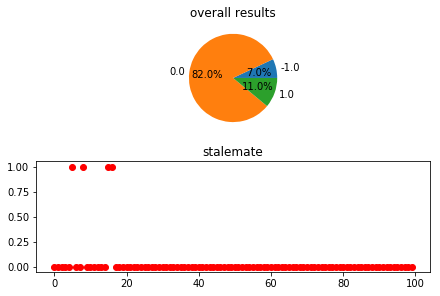

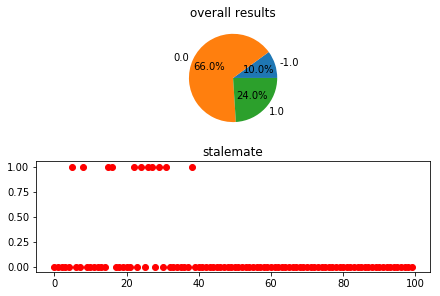

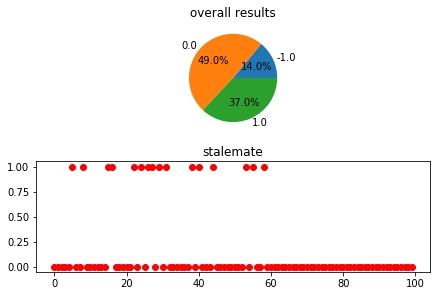

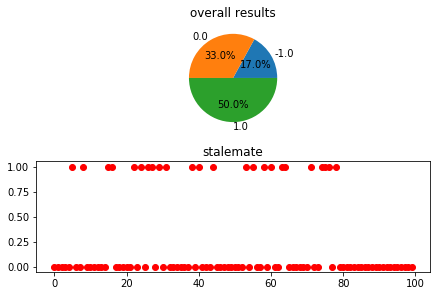

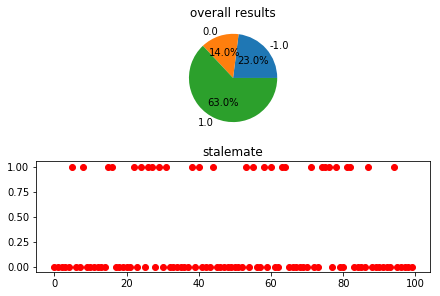

In [7]:
game = TicTacToe('DeepQAgent', 'DeepQAgent', p1_exporation=0.3333, p2_exporation=0.3333)
res = game.train(100, epochs=10, plot=True, plotEveryn=20, plotSave=True)
# game.play_pvp()

Model loaded: DeepQAgent1.h5


  1%|          | 1/100 [00:00<00:13,  7.30it/s]

Model loaded: DeepQAgent-1.h5


100%|██████████| 100/100 [00:01<00:00, 62.67it/s]
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


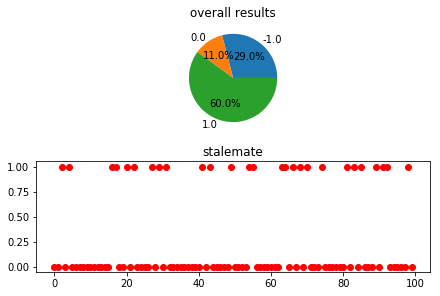

In [8]:
game = TicTacToe('DeepQAgent', 'DeepQAgent', p1_exporation=0, p2_exporation=0)
res = game.test(100)

In [9]:
game = TicTacToe('DeepQAgent', 'Human', p1_exporation=0.05)
game.play_pvp()

Model loaded: DeepQAgent1.h5
----------------
|  0 |  1 |  2 |
----------------
|  3 |  4 |  5 |
----------------
|  6 |  7 |  8 |
----------------
Turn:  1 Player:  1
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Turn:  2 Player:  -1
[[0 0 0]
 [0 0 1]
 [0 0 0]]
Choose move: 4
Turn:  3 Player:  1
[[ 0  0  0]
 [ 0 -1  1]
 [ 0  0  0]]
Turn:  4 Player:  -1
[[ 1  0  0]
 [ 0 -1  1]
 [ 0  0  0]]
Choose move: 2
Turn:  5 Player:  1
[[ 1  0 -1]
 [ 0 -1  1]
 [ 0  0  0]]
Turn:  6 Player:  -1
[[ 1  0 -1]
 [ 1 -1  1]
 [ 0  0  0]]
Choose move: 6
Player Human-1 ( -1 ) Won!
Final Board:
[[ 1  0 -1]
 [ 1 -1  1]
 [-1  0  0]]


In [ ]:
cuts = [50,100,150]
splits = np.split(res['whoWon'], cuts)
dat = np.zeros((3,len(splits)))
for x in range(len(splits)):
    try:
        dat[:,x] = np.unique(splits[x], return_counts=True)[1]
    except:
        pass


N = dat.shape[1]
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, dat[0,:], width)
p2 = plt.bar(ind, dat[1,:], width, bottom=dat[0,:])
p3 = plt.bar(ind, dat[2,:], width, bottom=dat[0,:]+dat[1,:])

plt.xticks(ind, cuts)
plt.legend((p1[0], p2[0], p3[0]), ('p1', 'stalemate', 'p2'))